In [16]:
from pathlib import Path
import uproot
import pandas as pd
import sys
import numpy as np
import warnings
import matplotlib.pyplot as plt

# PID weights and uncertainties

Here we calculate the PID effects by comparing data and MC for certain benchmark channels. For this we use the [systematics framework](https://syscorrfw.readthedocs.io/en/latest/index.html).

Fist we will obtain the PID corrwction tables, with uncertainties, then we will apply the weights to the ntuples and lastly we calculate the systematics table.

## Correction tables

This code will only run on KEKCC.

In [17]:
from IPython.display import HTML 

# Path to scripts on KEKCC
sys_path = '/group/belle2/dataprod/Systematics/systematic_corrections_framework/scripts'

sys.path.insert(1, sys_path)

sys.path.append('/group/belle2/dataprod/Systematics/systematic_corrections_framework')

import efficiency_table as et
import process_tables as pt
import show_db_content as sdb
import id_vs_misid_curve as roc
import weight_table as wm

Computing systematics related to the sys_sWeights:
	Max sys error: 1.30% mean sys error: 0.24%
Computing systematics related to the isSignal:
	Max sys error 31.99% mean sys error 1.39%
Computing systematics related to the sys_sWeights:
	Max sys error: 7.13% mean sys error: 0.34%


,p_min,p_max,cosTheta_min,cosTheta_max,data_MC_ratio,data_MC_uncertainty_stat_up,data_MC_uncertainty_stat_dn,data_MC_uncertainty_sys_up,data_MC_uncertainty_sys_dn,data_efficiency,...,data_uncertainty_stat_dn,data_uncertainty_sys_up,data_uncertainty_sys_dn,MC_efficiency,MC_uncertainty_stat_up,MC_uncertainty_stat_dn,MC_uncertainty_sys_up,MC_uncertainty_sys_dn,threshold,variable
0,0.5,0.9,-0.8660,-0.6820,0.638155,0.020086,0.020086,0.000271,0.000271,0.328305,...,0.005658,0.000981,0.000981,0.514460,0.005306,0.005306,0.002813,0.002813,0.9,kaonID
1,0.5,0.9,-0.6820,-0.4226,0.852260,0.005706,0.005706,0.000085,0.000085,0.653057,...,0.003025,0.002562,0.002562,0.766264,0.002554,0.002554,0.000240,0.000240,0.9,kaonID
2,0.5,0.9,-0.4226,-0.1045,0.983668,0.002625,0.002625,0.000123,0.000123,0.909331,...,0.001804,0.003763,0.003763,0.924428,0.001588,0.001588,0.000884,0.000884,0.9,kaonID
3,0.5,0.9,-0.1045,0.2250,0.962649,0.002880,0.002880,0.000001,0.000001,0.859147,...,0.001903,0.003594,0.003594,0.892482,0.001643,0.001643,0.001212,0.001212,0.9,kaonID
4,0.5,0.9,0.2250,0.5000,0.970906,0.003213,0.003213,0.000057,0.000057,0.844279,...,0.002063,0.003868,0.003868,0.869579,0.001813,0.001813,0.002696,0.002696,0.9,kaonID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4.1,4.5,-0.1045,0.2250,0.833430,0.047980,0.047980,0.000083,0.000083,0.355550,...,0.013665,0.000288,0.000288,0.426611,0.012253,0.012253,0.008630,0.008630,0.9,kaonID
76,4.1,4.5,0.2250,0.5000,0.870930,0.023213,0.023213,0.000893,0.000893,0.412619,...,0.007560,0.000398,0.000398,0.473768,0.006752,0.006752,0.011557,0.011557,0.9,kaonID
77,4.1,4.5,0.5000,0.7660,0.792337,0.010105,0.010105,0.000360,0.000360,0.540602,...,0.004521,0.000644,0.000644,0.682288,0.003871,0.003871,0.012221,0.012221,0.9,kaonID
78,4.1,4.5,0.7660,0.8829,0.902358,0.008899,0.008899,0.000236,0.000236,0.654697,...,0.004554,0.000971,0.000971,0.725540,0.004026,0.004026,0.013090,0.013090,0.9,kaonID


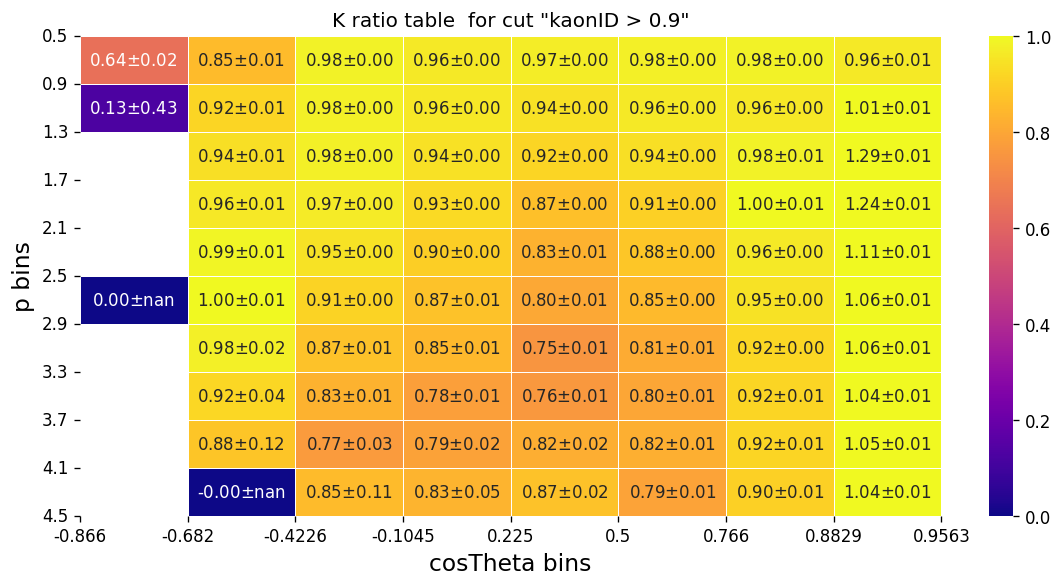

In [18]:
ratio_cfg = {
    "cut": "kaonID > 0.9",
    "particle_type": "K", #pi - efficiency max 5%
    "data_collection": "proc13+prompt",
    "mc_collection": "MC15ri",
    "track_variables": ["p", "cosTheta"],
    "precut": "nCDCHits > 20",
    "binning": [list(np.linspace(0.5, 4.5, 11)), 
                [-0.866, -0.682, -0.4226, -0.1045, 0.225, 0.5, 0.766, 0.8829, 0.9563]],
}
efficiency = wm.produce_data_mc_ratio(**ratio_cfg)

efficiency_table_K = efficiency.create_weights()
# Uncomment the following line to see the content 
# of the produced weight table in pandas DataFrame format:

efficiency_table_K.to_csv('pid-tables/efficiency_table_K.csv')
efficiency_table_K

Computing systematics related to the sys_sWeights:
	Max sys error: 83.84% mean sys error: 4.09%
Computing systematics related to the isSignal:
	Max sys error 401.54% mean sys error 12.02%
Computing systematics related to the sys_sWeights:
	Max sys error: 109.14% mean sys error: 3.63%
Number of excluded negative values: 2 
Excluded values are shown as hashed regions.


,p_min,p_max,cosTheta_min,cosTheta_max,data_MC_ratio,data_MC_uncertainty_stat_up,data_MC_uncertainty_stat_dn,data_MC_uncertainty_sys_up,data_MC_uncertainty_sys_dn,data_efficiency,...,data_uncertainty_stat_dn,data_uncertainty_sys_up,data_uncertainty_sys_dn,MC_efficiency,MC_uncertainty_stat_up,MC_uncertainty_stat_dn,MC_uncertainty_sys_up,MC_uncertainty_sys_dn,threshold,variable
0,0.5,0.9,-0.8660,-0.6820,0.362247,0.158527,0.158527,0.006801,0.006801,0.001560,...,0.000232,0.000024,0.000024,0.004307,0.000237,0.000237,0.000026,0.000026,0.9,kaonID
1,0.5,0.9,-0.6820,-0.4226,1.190114,0.025082,0.025082,0.008014,0.008014,0.012447,...,0.000233,0.000062,0.000062,0.010459,0.000175,0.000175,0.000515,0.000515,0.9,kaonID
2,0.5,0.9,-0.4226,-0.1045,1.607343,0.019710,0.019710,0.003608,0.003608,0.014921,...,0.000191,0.000002,0.000002,0.009283,0.000139,0.000139,0.000454,0.000454,0.9,kaonID
3,0.5,0.9,-0.1045,0.2250,1.584936,0.015464,0.015464,0.001443,0.001443,0.017501,...,0.000176,0.000005,0.000005,0.011042,0.000130,0.000130,0.000456,0.000456,0.9,kaonID
4,0.5,0.9,0.2250,0.5000,1.530380,0.015108,0.015108,0.002678,0.002678,0.015499,...,0.000151,0.000005,0.000005,0.010128,0.000117,0.000117,0.000331,0.000331,0.9,kaonID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4.1,4.5,-0.1045,0.2250,0.640674,0.456383,0.456383,0.003297,0.003297,0.028873,...,0.010517,0.000256,0.000256,0.045066,0.012391,0.012391,0.006736,0.006736,0.9,kaonID
76,4.1,4.5,0.2250,0.5000,0.942738,0.156617,0.156617,0.004871,0.004871,0.041532,...,0.004876,0.000094,0.000094,0.044055,0.004567,0.004567,0.004147,0.004147,0.9,kaonID
77,4.1,4.5,0.5000,0.7660,1.118333,0.098799,0.098799,0.006476,0.006476,0.035593,...,0.002529,0.000476,0.000476,0.031827,0.002185,0.002185,0.003225,0.003225,0.9,kaonID
78,4.1,4.5,0.7660,0.8829,1.850432,0.106610,0.106610,0.015104,0.015104,0.044974,...,0.002886,0.000460,0.000460,0.024305,0.002069,0.002069,0.002481,0.002481,0.9,kaonID


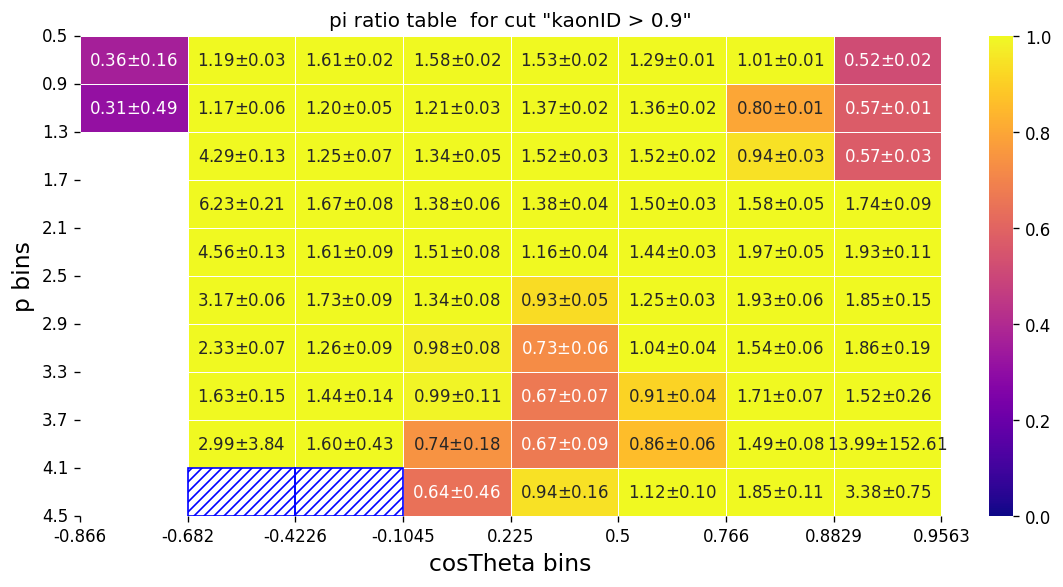

In [19]:
ratio_cfg = {
    "cut": "kaonID > 0.9",
    "particle_type": "pi", #pi - efficiency max 5%
    "data_collection": "proc13+prompt",
    "mc_collection": "MC15ri",
    "track_variables": ["p", "cosTheta"],
    "precut": "nCDCHits > 20",
    "binning": [list(np.linspace(0.5, 4.5, 11)), 
                [-0.866, -0.682, -0.4226, -0.1045, 0.225, 0.5, 0.766, 0.8829, 0.9563]],
}
efficiency = wm.produce_data_mc_ratio(**ratio_cfg)

efficiency_table_pi = efficiency.create_weights()
# Uncomment the following line to see the content 
# of the produced weight table in pandas DataFrame format:

efficiency_table_pi.to_csv('pid-tables/efficiency_table_pi.csv')
efficiency_table_pi

In [20]:
efficiency_table_K = pd.read_csv('pid-tables/efficiency_table_K.csv')
efficiency_table_pi = pd.read_csv('pid-tables/efficiency_table_pi.csv')

## Applying PID weights

This code will only run on KEKCC, as the corresponding samples are there. 

In [21]:
BASE = Path('/home/belle2/lorenzg/pyhf-tutorial/ntuples_reconstructed')
ntuples = {
    'data_ssbar'    : {BASE / 'MC15ri_b_Kpi0_generic_200fb_8/ssbar.root': 'Bsig'},
    'data_ccbar'    : {BASE / 'MC15ri_b_Kpi0_generic_200fb_8/ccbar.root': 'Bsig'},
    'data_charged'  : {BASE / 'MC15ri_b_Kpi0_generic_200fb_8/charged.root': 'Bsig'},
    'data_mixed'    : {BASE / 'MC15ri_b_Kpi0_generic_200fb_8/mixed.root': 'Bsig'},
    'signal'        : {BASE / 'MC15ri_b_Kpi0_signal_8/00.root': 'Bsig'},
    'signal_rmt'    : {BASE / 'MC15ri_b_Kpi0_signal_rmT_4/sub00/grid_00000_job348357260_00.root': 'Bsig'},
    'ssbar'         : {BASE / 'MC15ri_b_Kpi0_generic_200fb_9/ssbar.root' : 'Bsig'},
    'ssbar_rmt'     : {BASE / 'MC15ri_b_Kpi0_generic_200fb_9/ssbar_rmT.root': 'Bsig'},
    'ccbar'         : {BASE / 'MC15ri_b_Kpi0_generic_200fb_9/ccbar.root' : 'Bsig'},
    'ccbar_rmt'     : {BASE / 'MC15ri_b_Kpi0_generic_200fb_9/ccbar_rmT.root': 'Bsig'},
    'charged'       : {BASE / 'MC15ri_b_Kpi0_generic_200fb_9/charged.root': 'Bsig'},
    'charged_rmt'   : {BASE / 'MC15ri_b_Kpi0_generic_200fb_9/charged_rmT.root': 'Bsig'},
    'mixed'         : {BASE / 'MC15ri_b_Kpi0_generic_200fb_9/mixed.root': 'Bsig'},
    'mixed_rmt'     : {BASE / 'MC15ri_b_Kpi0_generic_200fb_9/mixed_rmT.root': 'Bsig'},
    'misID'         : {BASE / 'MC15ri_b_Kpi0_misID/misID.root': 'Bsig'},
    'misID_rmt'     : {BASE / 'MC15ri_b_Kpi0_misID/misID_rmT.root': 'Bsig'}    
}

cols = ['__production__', 'B_isSignal', 'B_deltaE', 'K_mcPDG',  'K_p', 'K_theta', 'B_R2', 'B_cosTBTO', 'B_mcErrors']
pid_cols = ['data_MC_ratio',
            'data_MC_uncertainty_stat_up', 'data_MC_uncertainty_stat_dn',
            'data_MC_uncertainty_sys_up', 'data_MC_uncertainty_sys_dn']
uproot.open({BASE / 'MC15ri_b_Kpi0_signal_8/00.root': 'Bsig'}).keys()

['__experiment__',
 '__run__',
 '__event__',
 '__production__',
 '__candidate__',
 '__ncandidates__',
 '__weight__',
 'Ecms',
 'B_Mbc',
 'B_deltaE',
 'B_isContinuumEvent',
 'B_R2',
 'B_thrustBm',
 'B_thrustOm',
 'B_cosTBTO',
 'B_cosTBz',
 'B_KSFWV_et',
 'B_KSFWV_mm2',
 'B_KSFWV_hso00',
 'B_KSFWV_hso01',
 'B_KSFWV_hso02',
 'B_KSFWV_hso03',
 'B_KSFWV_hso04',
 'B_KSFWV_hso10',
 'B_KSFWV_hso12',
 'B_KSFWV_hso14',
 'B_KSFWV_hso20',
 'B_KSFWV_hso22',
 'B_KSFWV_hso24',
 'B_KSFWV_hoo0',
 'B_KSFWV_hoo1',
 'B_KSFWV_hoo2',
 'B_KSFWV_hoo3',
 'B_KSFWV_hoo4',
 'B_CC1',
 'B_CC2',
 'B_CC3',
 'B_CC4',
 'B_CC5',
 'B_CC6',
 'B_CC7',
 'B_CC8',
 'B_CC9',
 'B_foxWolframR1',
 'B_foxWolframR4',
 'B_thrustAxisCosTheta',
 'B_DeltaZ',
 'B_DeltaZErr',
 'B_TagVReChi2',
 'B_TagVReChi2IP',
 'B_TagVx',
 'B_TagVxErr',
 'B_TagVy',
 'B_TagVyErr',
 'B_TagVz',
 'B_TagVzErr',
 'B_TagVNTracks',
 'B_daughterAngle',
 'B_daughterAngle_CMS',
 'B_daughterDiff_phi',
 'B_daughterDiff_CMS_phi',
 'B_daughterDiff_theta',
 'B_daughter

In [22]:
def get_weight(p, th, eff, var):
    costh = np.cos(th)
    return eff.query('@p >= p_min and @p < p_max and @costh >= cosTheta_min and @costh < cosTheta_max')[var]

nK = 0
npi= 0

kPDG = 321
piPDG = 211

for k,v in ntuples.items():
    df = uproot.concatenate(v, cols, library='pd')

    rows = [[row['K_p'], row['K_theta'], row['K_mcPDG']] for _, row in df.iterrows()]
    
    pid_weights = pd.DataFrame(data=None, columns=pid_cols)
    for r in rows:
        if np.abs(r[2]) == kPDG:
            nK += 1
            w = get_weight(r[0], r[1], efficiency_table_K, pid_cols)
        elif np.abs(r[2]) == piPDG:
            npi += 1
            w = get_weight(r[0], r[1], efficiency_table_pi, pid_cols)
        else:
            w = pd.DataFrame(data=[[1,0,0,0,0]], columns=pid_cols)
        pid_weights  = pd.concat([pid_weights, w], ignore_index=True, sort=False)
        
    for v in pid_cols:
        df[v] = pid_weights[v]
    
    # add total uncertainty
    unc = np.sqrt(((pid_weights[pid_cols[1]].astype(float)+pid_weights[pid_cols[2]].astype(float))/2.)**2 
                    + ((pid_weights[pid_cols[3]].astype(float)+pid_weights[pid_cols[4]].astype(float))/2.)**2)
    df['PID_total_uncertainty'] = unc
        
    print(k, df.info())
    with uproot.recreate(f'ntuples/{k}.root') as file:
        file['B'] = df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19668 entries, 0 to 19667
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   __production__               19668 non-null  int32  
 1   B_isSignal                   19595 non-null  float64
 2   B_deltaE                     19668 non-null  float64
 3   K_mcPDG                      19646 non-null  float64
 4   K_p                          19668 non-null  float64
 5   K_theta                      19668 non-null  float64
 6   B_R2                         19668 non-null  float64
 7   B_cosTBTO                    19668 non-null  float64
 8   B_mcErrors                   19668 non-null  float64
 9   data_MC_ratio                19668 non-null  float64
 10  data_MC_uncertainty_stat_up  19668 non-null  float64
 11  data_MC_uncertainty_stat_dn  19668 non-null  float64
 12  data_MC_uncertainty_sys_up   19668 non-null  float64
 13  data_MC_uncertai

In [23]:
print(nK, npi)

235350 52942


## Calculating systematic corrections

In [24]:
def getBin(df, var, bins):
    '''
        Determine bin numbers for the 2D->1D
        Input:
            df: input dataframe (or lazyarray)
            binning: bin edges of the fitting binning
        Output:
           np.array of 2D bin numbers. For entries outside bin boundaries, returns 0 or len1*len2+1.

        Example usage:
           dSig = getBin2D(sig[sig.bdt_v24_ff_weights>0.9],'B_sig_K_pt__vs__bdt_v24_ff_weights_T09')
           h = plt.hist(dSig[(dSig>0)&(dSig<13)],13,(1.,13.))
    '''
    # 1-d digitize:
    out = np.digitize(df[var], bins)
    return out


def identify_mc_category(prod_id):
    ''' Identify a MC category from a production number
    '''
    if prod_id in [25052] :
        return 'signal'
    elif prod_id in [24787, 24797] :
        return 'qqbar'
    elif prod_id in [24817, 24822]:
        return 'BBbar'
    elif prod_id in [26308]:
        return 'misID'

    else:
        warnings.warn(f"{prod_id} category unknown.")
        return 'unknown'
    
v_category = np.vectorize(identify_mc_category)

class PIDstatErrorPropagator:
    '''
       Class to compute covariance matrix for PID stat. uncertainties.
    '''

    def __init__(self, df, bins, varStat, nrep=500):
        '''
           Input variables:
              df   : mc sample. Should include all productions (signal + backgrounds)
              bins: bin edges of the fitting binning
              varStat : PID stat. error
              nrep : number of toy MC replica
        '''
        keys = set(np.nan_to_num(df[varStat]))
        self.df = df
        self.bins = bins
        self.len = len(keys)
        self.varStat = varStat
        self.nrep = nrep
        print("len=", self.len)
        self.toys = dict()
        for key in keys:
            toy = np.random.lognormal(0., min(key, 1.), nrep)
            self.toys[key] = toy

    def getW(self):
        ''' Return array of weight uncertainties for each event
            Output:
              out :  array ( len(df),  self.nrep ) of weight errors per event
        '''
        a = np.nan_to_num(np.array(self.df[self.varStat]))
        out = np.zeros((len(a), self.nrep))
        for i in range(len(a)):
            out[i] = self.toys[a[i]]
        return out

    def cov(
        self,
        var,
        prods=[
            'signal',
            'qqbar',
            'BBbar',
            'misID']):
        '''
            Compute covariance matrix for df and fit bins

            Input variables:
               var : variable name in variable_registry
               prods : event categories

            Output:
               av    : sum of weights for each bin, each event category.
                       Dimention of av is given by Ncategories x Nbins
               cov   : covariance matrix
               prods : same as input (useful if default value is used)
        '''
        prod = v_category(self.df.__production__)
        www = self.getW()
        dSig = getBin(self.df, var, self.bins)
        nbin = len(self.bins)-1
        # over bins
        out = np.zeros((nbin*len(prods), self.nrep))
        for j, p in enumerate(prods):
            for i in range(nbin):
                out[j*nbin+i] = np.sum(www[(dSig == i+1) & (p == prod)], axis=0)

        av = np.average(out, axis=1)
        dd = out-av[:, np.newaxis]
        cov = np.sum(dd[np.newaxis, :, :]*dd[:, np.newaxis, :], axis=2)/self.nrep
        return av, cov, prods
    
def covToNui(cov):
    '''
    Perform decoposition of covariance matrix cov

    Input variables:
        cov : covariance matrix
    Output variables:
        vec : eigenvectors, ordered with most significant being the last
    '''
    va, ve = np.linalg.eigh(cov)
    diag = np.identity(len(va))
    va = np.where(va > 0, va, 0)
    sva = np.sqrt(va)*diag
    pa = ve.dot(sva)  # error vectors, to use with "nuisance parameters"
    return np.transpose(pa)

def truncateNui(vec, n):
    '''
    Keep only N most significant eigenvectors, cut the rest

    Input variables:
        vec : input eigenvectors
        n   : number of eigenvectors to keep

    Output:
        dia  : uncorrelated part, to be added to stat. uncertainty in quadrature
        ovec : remaining correlated eigenvectors
    '''
    s = vec.shape[0]
    ovec = vec[s-n:s]
    odia = vec[:s-n]
    dia = np.sqrt(np.sum(odia**2, axis=0))
    return dia, ovec

def check_array(x):
    try:
        x.shape
        return True
    except:
        return False

def dumpSyst(dia, ovec, cent, names, fname):
    '''
        Store results in a csv file.

        Input variables:
           dia  : array of uncorrelated uncertainties (or None)
           ovec : matrix of correlated eigenvectors
           cent : central values
           names: names of categories
           fname: output file name
        Output:
           creates a comma separated table "fname"
           column "type" has value "u" for uncorrelated and "c" for correlated uncertainty
           other colums encode bin/category info, e.g.  "signal_10"
    '''
    isDia = check_array(dia)
    
    if isDia == False:
        pass
    else:
        d = np.where(cent > 0, dia/cent, 0)
    v = np.where(cent > 0, ovec/cent, 0)

    ln = len(names)
    if isDia == False:
        lo = ovec.shape[1]
    else:
        lo = len(dia)
    lb = lo // ln
    with open(fname, "w") as f:
        s = "type"
        for n in names:
            for b in range(lb):
                s += ",{}_{}".format(n, b+1)
        f.write(s+"\n")

        if isDia:
            f.write("u," + ",".join(["{:6.3f}".format(d) for d in d*100]) + "\n")
        if (len(v.shape) > 1): 
            for i,vv in enumerate(v[:]):
                f.write("c{},".format(i+1) + ",".join(["{:6.3f}".format(d) for d in vv*100]) + "\n")
        else:
            f.write("c," + ",".join(["{:6.3f}".format(d) for d in v*100]) + "\n")


In [25]:
productions = ['signal', 'ssbar', 'ccbar', 'charged', 'mixed', 'misID']
cols = ['__production__', 'B_isSignal', 'B_deltaE', 'K_mcPDG',  'K_p', 'K_theta', 'B_R2', 'B_cosTBTO', 'B_mcErrors']
files = [{f'ntuples/{p}.root':'B'} for p in productions]
all = uproot.concatenate(files, cols+pid_cols+['PID_total_uncertainty'], library='pd')
all.head()

,__production__,B_isSignal,B_deltaE,K_mcPDG,K_p,K_theta,B_R2,B_cosTBTO,B_mcErrors,data_MC_ratio,data_MC_uncertainty_stat_up,data_MC_uncertainty_stat_dn,data_MC_uncertainty_sys_up,data_MC_uncertainty_sys_dn,PID_total_uncertainty
0,25052,1.0,0.039363,-321.0,3.404785,0.583449,0.540352,0.804686,0.0,0.915756,0.005541,0.005541,0.000085,0.000085,0.005541
1,25052,1.0,-0.120635,-321.0,2.934658,0.752467,0.503526,0.884052,0.0,0.808654,0.005659,0.005659,0.000060,0.000060,0.005659
2,25052,1.0,0.081343,-321.0,2.852392,1.183308,0.298600,0.488273,0.0,0.801125,0.006859,0.006859,0.000182,0.000182,0.006861
3,25052,1.0,0.206142,-321.0,3.293716,0.393552,0.278345,0.687062,0.0,1.055828,0.005691,0.005691,0.000016,0.000016,0.005691
4,25052,1.0,0.019155,-321.0,3.216509,0.677814,0.578883,0.874186,0.0,0.919989,0.004935,0.004935,0.000014,0.000014,0.004936


In [26]:
bins = np.linspace(-0.4, 0.4, 20 + 1)
pid = PIDstatErrorPropagator(all, bins, varStat='PID_total_uncertainty', nrep=500)

sigAv, sigCov, pnames = pid.cov('B_deltaE')

len= 56


In [27]:
vec = covToNui(sigCov)

/tmp/ipykernel_190558/1051545928.py:9: RuntimeWarning: invalid value encountered in true_divide
  ra = np.where(rr>0,sigCov/rr,0)


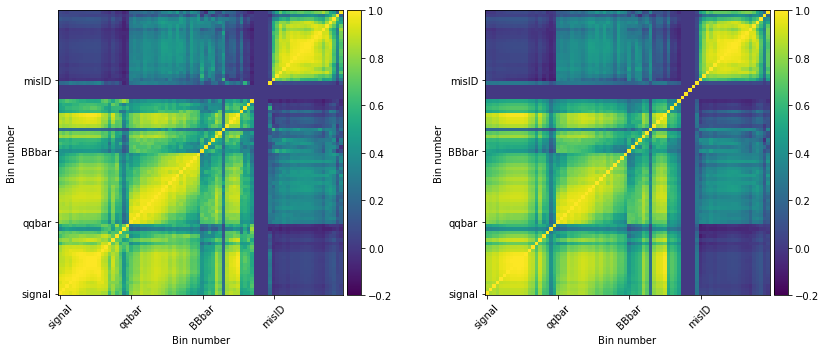

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_labels = {'signal': 'signal', 'qqbar': 'qqbar', 'BBbar': 'BBbar', 'misID': 'misID'}

N = 5

fig, ax = plt.subplots(1,2,figsize=(12,5))
di = np.diag(sigCov)
rr = np.sqrt(di[np.newaxis,:]*di[:,np.newaxis])
ra = np.where(rr>0,sigCov/rr,0)
im = ax[0].imshow(ra,vmin=-0.2,vmax=1,origin='lower')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)
ax[0].set_xticks(np.arange(0,80,20))
ax[0].set_xticklabels([_labels[p] for p in pnames], rotation=45)
ax[0].set_yticks(np.arange(0,80,20))
ax[0].set_yticklabels([_labels[p] for p in pnames], rotation=0)
ax[0].set_xlabel('Bin number')
ax[0].set_ylabel('Bin number')

d,v =truncateNui(vec,N)
cov2 = np.transpose(v).dot(v) +np.identity(len(d))*d**2

di = np.diag(cov2)
rr = np.sqrt(di[np.newaxis,:]*di[:,np.newaxis])
ra = np.where(rr>0,cov2/rr,0)
im = ax[1].imshow(ra,vmin=-0.2,vmax=1,origin='lower')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)
ax[1].set_xticks(np.arange(0,80,20))
ax[1].set_xticklabels([_labels[p] for p in pnames], rotation=45) #45
ax[1].set_yticks(np.arange(0,80,20))
ax[1].set_yticklabels([_labels[p] for p in pnames], rotation=0)
ax[1].set_xlabel('Bin number')
ax[1].set_ylabel('Bin number')

fig.tight_layout()
fig.patch.set_facecolor('white')

In [29]:
dumpSyst(d, v, sigAv, pnames, 'pid-tables/pid_systematics.csv')

/tmp/ipykernel_190558/2549765892.py:170: RuntimeWarning: divide by zero encountered in true_divide
  d = np.where(cent > 0, dia/cent, 0)
/tmp/ipykernel_190558/2549765892.py:171: RuntimeWarning: invalid value encountered in true_divide
  v = np.where(cent > 0, ovec/cent, 0)
